In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:

Path.cwd()

PosixPath('/Users/sonya0706/Documents/CSI/payload-2025-26/model')

In [3]:
# Reading simulated data from sim
BASE_DIR = Path.cwd()          # model/
csv_path = BASE_DIR.parent / "sim" / "calisto_flight_data.csv"

df = pd.read_csv(csv_path)

In [4]:
df.head()

,# Time (s),acceleration Magnitude (m/s²),Vz (m/s),Z (m)
0,0.000000,71.195328,0.000000,906.565430
1,0.006110,71.204258,0.433378,906.568077
2,0.012219,71.213147,0.866811,906.573373
3,0.022219,71.227608,1.576304,906.585589
4,0.032219,71.241932,2.285941,906.604900


In [5]:
# Rename columns
df = df.rename(columns = {"# Time (s)":"time", " acceleration Magnitude (m/s²)":"acceleration", " Vz (m/s)":"vz", " Z (m)":"z"})

In [6]:
# set index time 
df = df.sort_values("time").reset_index(drop=True)
df

,time,acceleration,vz,z
0,0.000000,71.195328,0.000000,906.565430
1,0.006110,71.204258,0.433378,906.568077
2,0.012219,71.213147,0.866811,906.573373
3,0.022219,71.227608,1.576304,906.585589
4,0.032219,71.241932,2.285941,906.604900
...,...,...,...,...
35605,355.469250,0.020294,-5.388236,906.732272
35606,355.479250,0.020294,-5.388219,906.678390
35607,355.489250,0.020294,-5.388202,906.624508
35608,355.499250,0.020294,-5.388185,906.570626


In [7]:
# normalize features
features = ["acceleration", "vz", "z"]
X_raw = df[features].to_numpy()   # (T, 3)

mu = X_raw.mean(axis=0, keepdims=True)
sigma = X_raw.std(axis=0, keepdims=True) + 1e-8

X_norm = (X_raw - mu) / sigma

In [8]:
df[features] = X_norm

In [10]:
df[features].describe()

,acceleration,vz,z
count,3.561000e+04,3.561000e+04,3.561000e+04
mean,-2.873298e-17,1.117394e-17,2.298639e-16
std,1.000014e+00,1.000014e+00,1.000014e+00
min,-2.456313e-01,-3.997062e-01,-1.236714e+00
25%,-2.443032e-01,-3.692524e-01,-8.970844e-01
50%,-2.422952e-01,-3.414056e-01,-2.655875e-01
75%,-2.392441e-01,-1.101503e-01,8.736883e-01
max,7.704524e+00,6.382791e+00,1.917674e+00


In [11]:
assert not df[features].isna().any().any()
assert np.isfinite(df[features].to_numpy()).all()

Makeing Sliding Windows

In [25]:
def make_windows(X, window_len=52, stride=13):
    windows = []
    for start in range(0, len(X) - window_len + 1, stride):
        windows.append(X[start:start + window_len])
    return np.stack(windows)

X = X_norm      # (T, 3)
X_win = make_windows(X, 52, 13)  

In [26]:
print(X_win.shape)

(2736, 52, 3)


Testing Out Model 

In [34]:
# Read model from .py file
from cnn1d import CAE1D

In [35]:
model = CAE1D(window_length=52)
ae = model.build_cnn1d_autoencoder()
ae.summary()

Model: "1DCAE_unsupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 52, 3)]           0         
                                                                 
 encoder_1dcae (Functional)  (None, 13, 32)            3344      
                                                                 
 decoder_1dcae (Functional)  (None, None, 3)           4803      
                                                                 
Total params: 8,147
Trainable params: 8,147
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Training model 
history = ae.fit(
    X_win,
    X_win,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/50
77/77 [==============================] - 1s 3ms/step - loss: 0.5082 - val_loss: 0.0343
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4633 - val_loss: 0.0230
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4575 - val_loss: 0.0229
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4542 - val_loss: 0.0212
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4523 - val_loss: 0.0226
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4511 - val_loss: 0.0196
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4500 - val_loss: 0.0173
Epoch 8/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4491 - val_loss: 0.0146
Epoch 9/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4482 - val_loss: 0.0153
Epoch 10/50
77/77 [==============================] - 0s 2ms/step - loss: 0.4479 - val_loss: 0.0134
Epoch 11/50
77/77 [

In [37]:
# Reconstruction and anomaly score
X_hat = ae.predict(X_win)
recon_error = np.mean((X_win - X_hat)**2, axis=(1, 2))

86/86 [==============================] - 0s 784us/step


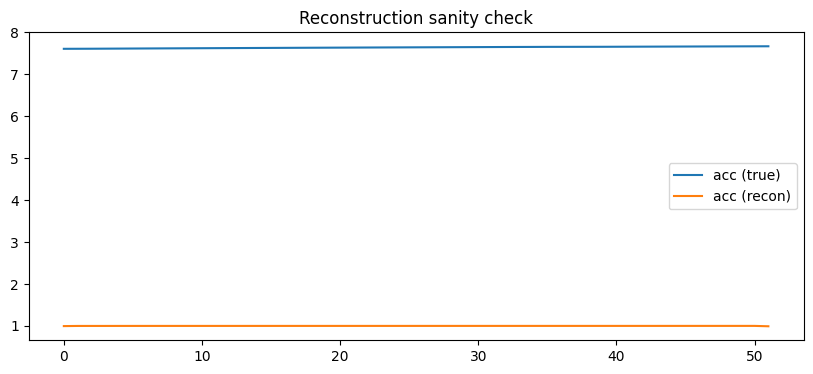

In [38]:
i = 0

plt.figure(figsize=(10, 4))
plt.plot(X_win[i, :, 0], label="acc (true)")
plt.plot(X_hat[i, :, 0], label="acc (recon)")
plt.legend()
plt.title("Reconstruction sanity check")
plt.show()

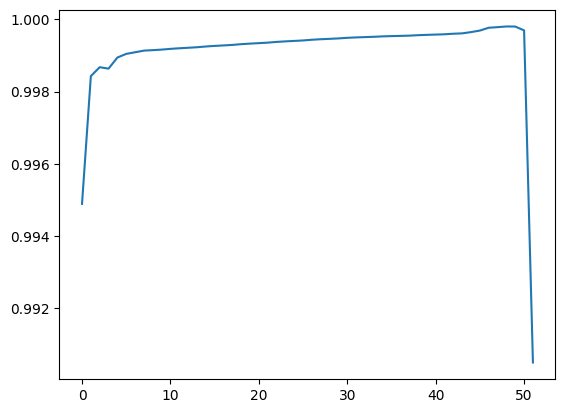

In [40]:
plt.plot(X_hat[i, :, 0])

In [33]:
X_norm.min(), X_norm.max()

(-1.236713935329408, 7.7045241823090755)